## Non-variational fixed-depth Hamiltonian simulation

Here we time the FDHS example with non-variational KAK decomposition.

In [1]:
from itertools import combinations, product
import numpy as np
import time
np.random.seed(2415)
from scipy.linalg import expm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)

import pennylane as qml
from pennylane import X, Y, Z, I
from pennylane.pauli import PauliWord, PauliSentence

from kak_tools import (
    map_simple_to_irrep,
    map_irrep_to_matrices,
    lie_closure_pauli_words,
    recursive_bdi,
    map_recursive_decomp_to_reducible,
    irrep_dot,
    make_signs,
    make_so_2n,
    make_so_2n_horizontal_mapping,
    make_so_2n_full_mapping,
    ai_kak,
)

In [2]:
# from pennylane.labs.dla import lie_closure_dense, batched_pauli_decompose
# n = 4

# assert n%2==0
# generators_u = (
#     [X(i) @ X(i+1) + X(n-i-2) @ X(n-1-i) for i in range(n//2)]
#     + [Y(i) @ Y(i+1) + Y(n-i-2) @ Y(n-1-i) for i in range(n//2)]
#     + [Z(i) + Z(n-1-i) for i in range(n//2)]
# )
# generators_so = (
#     generators_u
#     + [X(i) @ X(i+1) - X(n-i-2) @ X(n-1-i) for i in range(n//2)]
#     + [Y(i) @ Y(i+1) - Y(n-i-2) @ Y(n-1-i) for i in range(n//2)]
#     + [Z(i) - Z(n-1-i) for i in range(n//2)]
# )
# u_n = lie_closure_dense(generators_u)
# so_2n = lie_closure_dense(generators_so)
# print(2 * n**2 -n, len(so_2n))
# print(n**2, len(u_n))
# u_n = batched_pauli_decompose(u_n)

In [3]:
# Here we look at the symmetric subsector of the AI involution Ad_{H_XY} 

def coeffs_to_red_ham(alpha, beta):
    return (
        qml.dot(alpha, [X(i) @ X(i+1) + Y(i) @ Y(i+1) for i in range(len(alpha))])
        + qml.dot(beta, [Z(i) for i in range(len(beta))])
    )

def coeffs_to_irred_ham(alpha, beta):
    return np.diag(2j * beta) + np.diag(2*alpha, k=1) - np.diag(2*alpha, k=-1)



In [4]:
n = 6
alpha = np.random.normal(1., 0.5, size=n-1)
beta = np.random.normal(0., 0.5, size=n)
beta -= np.mean(beta) # Map to su(n)

H_irrep = coeffs_to_irred_ham(alpha, beta)
assert np.isclose(np.trace(H_irrep), 0.)
assert np.allclose(H_irrep.conj().T, -H_irrep)

In [5]:
time = 0.04

U = expm(time * H_irrep)
assert np.isclose(np.linalg.det(U), 1.)

k_1, a, k_2 = ai_kak(U, verify=True)
assert np.isclose(np.linalg.det(k_1), 1/np.linalg.det(k_2))
print(np.linalg.det(k_1))
assert np.isclose(np.linalg.det(a), 1.)
# assert np.isclose(np.linalg.det(k_2), 1.)

decomp_k_1 = recursive_bdi(k_1, n, first_is_horizontal=False)
decomp_k_2 = recursive_bdi(k_2, n, first_is_horizontal=False)

(1+2.7962605999934854e-17j)


{-1: [(array([[-1.   +0.j, -0.   -0.j,  0.029+0.j,  0.   -0.j,  0.   -0.j,  0.   -0.j],
          [ 0.029+0.j, -0.003+0.j,  1.   +0.j,  0.   -0.j,  0.   -0.j,  0.   -0.j],
          [ 0.   +0.j,  1.   +0.j,  0.003-0.j,  0.004-0.j, -0.   +0.j,  0.   +0.j],
          [-0.   -0.j, -0.004+0.j, -0.   +0.j,  0.999+0.j,  0.031+0.j,  0.002-0.j],
          [-0.   +0.j,  0.   -0.j,  0.   -0.j, -0.032-0.j,  0.997+0.j,  0.07 -0.j],
          [ 0.   -0.j, -0.   +0.j, -0.   +0.j, -0.   +0.j, -0.07 +0.j,  0.998+0.j]]),
   0,
   6,
   None)],
 0: [(array([[-1.   -0.j, -0.028-0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j],
          [ 0.028+0.j, -1.   -0.j,  0.002+0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j],
          [ 0.   +0.j,  0.002+0.j,  1.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j],
          [ 0.   +0.j,  0.   +0.j,  0.   +0.j, -0.029-0.j, -0.015+0.j,  0.999+0.j],
          [ 0.   +0.j,  0.   +0.j,  0.   +0.j, -0.859-0.j, -0.511-0.j, -0.032-0.j],
          [ 0.   +0.j,  0.   +0.j,  0.   +0.

In [19]:
# Config

coefficients = "random TF"
use_predefined_algebra = True
use_predefined_horizontal_mapping = True
use_hardcoded_mapping = True
ns = np.arange(2, 20, dtype=int) ** 2
# ns = [10]

In [20]:
def make_u_n(n):
    # Diagonal
    mapping = {(i, i, "+"): PauliWord({i:"Z"}) for i in range(n)}

    for i in range(n-1): # Iterate over number of Z's
        for j in range(n-i-1): # Iterate over starting index of PauliWord
            mapping[(j, i + 1 + j, "-")] = PauliWord({j: "X", j+i+1: ("X" if i % 2 == 0 else "Y")} | {w: "Z" for w in range(j+1, j+i+1)})
            mapping[(j, i + 1 + j, "+")] = PauliWord({j: "X", j+i+1: ("X" if i % 2 == 1 else "Y")} | {w: "Z" for w in range(j+1, j+i+1)})

    return mapping

def pw_to_op(pw):
    """Translate a PauliWord used in the encoding/mapping of u(n) to the correct full qubit operator,
    which will be a PauliSentence with one (diagonal encoding) or two (off-diagonal) words each."""
    if len(pw) == 1:
         # Only single-qubit ops are `PauliZ` terms
        return PauliSentence({pw: 1.})
        
    s, e = min(pw), max(pw)
    comb = pw[s] + pw[e]
    if comb == "XX":
        yy_pw = dict(pw)
        yy_pw[s] = yy_pw[e] = "Y"
        return PauliSentence({pw: 1., PauliWord(yy_pw): 1.})
    if comb == "XY":
        yx_pw = dict(pw)
        yx_pw[s] = "Y"
        yx_pw[e] = "X"
        return PauliSentence({pw: 1., PauliWord(yx_pw): -1.})

# def node_commutator(n1, n2):
#     new_sign = "-" if n1[2] == n2[2] else "+"
#     if n1[0] == n2[0]:
#         return (n1[1], n2[1], new_sign), 
#     if n1[0] == n2[1]:
#         return (n1[1], n2[0], new_sign)
#     if n1[1] == n2[0]:
#         return (n1[0], n2[1], new_sign)
#     if n1[1] == n2[1]:
#         return (n1[0], n2[0], new_sign)

In [ ]:
n = 8
H, generators, coeffs = make_u_n_hamiltonian(n, coefficients)
# n_so = 2 * n
n_u = n
# so_dim = (n_so**2-n_so) // 2
u_dim = n_u ** 2

if use_predefined_algebra:
    mapping = make_u_n(4)
    algebra = list(mapping.values())
else:
    raise NotImplementedError
    # algebra = lie_closure_pauli_words(generators, verbose=False)

assert len(algebra) == u_dim, f"{len(algebra)}, {u_dim}"

if not use_hardcoded_mapping:
    raise NotImplementedError
    if use_predefined_horizontal_mapping:
        horizontal_ops = make_so_2n_horizontal_mapping(n)
    else:
        horizontal_ops = generators
    # print(f"Mapping simple to irrep")
    mapping, signs = map_simple_to_irrep(algebra, horizontal_ops=horizontal_ops, n=n_so, invol_type="BDI", invol_kwargs={"p": n_so//2, "q": (n_so+1)//2})
    # print(f"Mapping irrep to matrices")
else:
    # mapping = make_so_2n_full_mapping(n)
    signs = {key: 1. for key in mapping}
    # signs = make_signs(mapping, n_so, "BDI")

epsilon = 0.01
# print(f"Computing H and time evolution")
H_irrep = irrep_dot(coeffs, generators, mapping, signs, n=n_so, invol_type="BDI")
U = expm(epsilon * H_irrep)

# print(f"Computing recursive decomposition")
start_decomposing = time.process_time()
recursive_decomp = recursive_bdi(U, n_so)
end_decomposing = time.process_time()

# print(f"Mapping recursive decomposition to Paulis")
start_mapping_back = time.process_time()
pauli_decomp = map_recursive_decomp_to_reducible(recursive_decomp, mapping, signs, invol_type="BDI", time=epsilon, tol=None, assertions=False)
end_mapping_back = time.process_time()
paulirot_decomp = [(coeff, qml.pauli.pauli_word_to_string(pw), pw.wires, _type) for pw, coeff, _type in pauli_decomp]

end = time.process_time()

times_mapping.append(end_mapping - start_mapping)
times_decomposing.append(end_decomposing - start_decomposing)
times_mapping_back.append(end_mapping_back - start_mapping_back)
times_total.append(end - start)
times_rest.append(times_total[-1] - times_mapping[-1] - times_mapping_back[-1] - times_decomposing[-1])

print(f"Decomposed exp(iHt) on {n} qubits into {len(paulirot_decomp)} Pauli rotations (DLA dimension: {so_dim}, Duration: {times_total[-1]:.3}s).")

In [4]:
times_mapping = []
times_decomposing = []
times_mapping_back = []
times_rest = []
times_total = []

for n in ns:
    n = int(n)
    H, generators, coeffs = make_so_2n_hamiltonian(n, coefficients)
    n_so = 2 * n
    so_dim = (n_so**2-n_so) // 2
    
    start = time.process_time()

    if use_predefined_algebra:
        algebra = make_so_2n(n)
    else:
        algebra = lie_closure_pauli_words(generators, verbose=False)
    start = time.process_time()
    assert len(algebra) == so_dim, f"{len(algebra)}, {so_dim}"

    start_mapping = time.process_time()

    if not use_hardcoded_mapping:
        if use_predefined_horizontal_mapping:
            horizontal_ops = make_so_2n_horizontal_mapping(n)
        else:
            horizontal_ops = generators
        # print(f"Mapping simple to irrep")
        mapping, signs = map_simple_to_irrep(algebra, horizontal_ops=horizontal_ops, n=n_so, invol_type="BDI", invol_kwargs={"p": n_so//2, "q": (n_so+1)//2})
        # print(f"Mapping irrep to matrices")
    else:
        mapping = make_so_2n_full_mapping(n)
        signs = make_signs(mapping, n_so, "BDI")

    end_mapping = time.process_time()

    epsilon = 0.01
    # print(f"Computing H and time evolution")
    H_irrep = irrep_dot(coeffs, generators, mapping, signs, n=n_so, invol_type="BDI")
    U = expm(epsilon * H_irrep)

    # print(f"Computing recursive decomposition")
    start_decomposing = time.process_time()
    recursive_decomp = recursive_bdi(U, n_so)
    end_decomposing = time.process_time()

    # print(f"Mapping recursive decomposition to Paulis")
    start_mapping_back = time.process_time()
    pauli_decomp = map_recursive_decomp_to_reducible(recursive_decomp, mapping, signs, invol_type="BDI", time=epsilon, tol=None, assertions=False)
    end_mapping_back = time.process_time()
    paulirot_decomp = [(coeff, qml.pauli.pauli_word_to_string(pw), pw.wires, _type) for pw, coeff, _type in pauli_decomp]

    end = time.process_time()
    
    times_mapping.append(end_mapping - start_mapping)
    times_decomposing.append(end_decomposing - start_decomposing)
    times_mapping_back.append(end_mapping_back - start_mapping_back)
    times_total.append(end - start)
    times_rest.append(times_total[-1] - times_mapping[-1] - times_mapping_back[-1] - times_decomposing[-1])
    
    print(f"Decomposed exp(iHt) on {n} qubits into {len(paulirot_decomp)} Pauli rotations (DLA dimension: {so_dim}, Duration: {times_total[-1]:.3}s).")

Decomposed exp(iHt) on 4 qubits into 28 Pauli rotations (DLA dimension: 28, Duration: 0.00564s).
Decomposed exp(iHt) on 9 qubits into 153 Pauli rotations (DLA dimension: 153, Duration: 0.0221s).
Decomposed exp(iHt) on 16 qubits into 496 Pauli rotations (DLA dimension: 496, Duration: 0.0475s).
Decomposed exp(iHt) on 25 qubits into 1225 Pauli rotations (DLA dimension: 1225, Duration: 0.146s).
Decomposed exp(iHt) on 36 qubits into 2552 Pauli rotations (DLA dimension: 2556, Duration: 0.288s).
Decomposed exp(iHt) on 49 qubits into 4731 Pauli rotations (DLA dimension: 4753, Duration: 0.582s).
Decomposed exp(iHt) on 64 qubits into 8044 Pauli rotations (DLA dimension: 8128, Duration: 0.607s).


/home/david/repos/kak-tools/kak_tools/dense_cartan.py:179: RuntimeWarning: invalid value encountered in arcsin
  angle = np.arcsin(matrix[i, j])


Decomposed exp(iHt) on 81 qubits into 12879 Pauli rotations (DLA dimension: 13041, Duration: 1.18s).
Decomposed exp(iHt) on 100 qubits into 19666 Pauli rotations (DLA dimension: 19900, Duration: 1.62s).
Decomposed exp(iHt) on 121 qubits into 28857 Pauli rotations (DLA dimension: 29161, Duration: 2.06s).
Decomposed exp(iHt) on 144 qubits into 40776 Pauli rotations (DLA dimension: 41328, Duration: 3.63s).
Decomposed exp(iHt) on 169 qubits into 56213 Pauli rotations (DLA dimension: 56953, Duration: 5.16s).
Decomposed exp(iHt) on 196 qubits into 75542 Pauli rotations (DLA dimension: 76636, Duration: 6.69s).
Decomposed exp(iHt) on 225 qubits into 99755 Pauli rotations (DLA dimension: 101025, Duration: 8.57s).
Decomposed exp(iHt) on 256 qubits into 129109 Pauli rotations (DLA dimension: 130816, Duration: 10.9s).
Decomposed exp(iHt) on 289 qubits into 164757 Pauli rotations (DLA dimension: 166753, Duration: 17.7s).
Decomposed exp(iHt) on 324 qubits into 207274 Pauli rotations (DLA dimension: 

/tmp/ipykernel_3796958/1352928734.py:7: RuntimeWarning: invalid value encountered in power
  f = lambda x, a, b: (b * x)**a


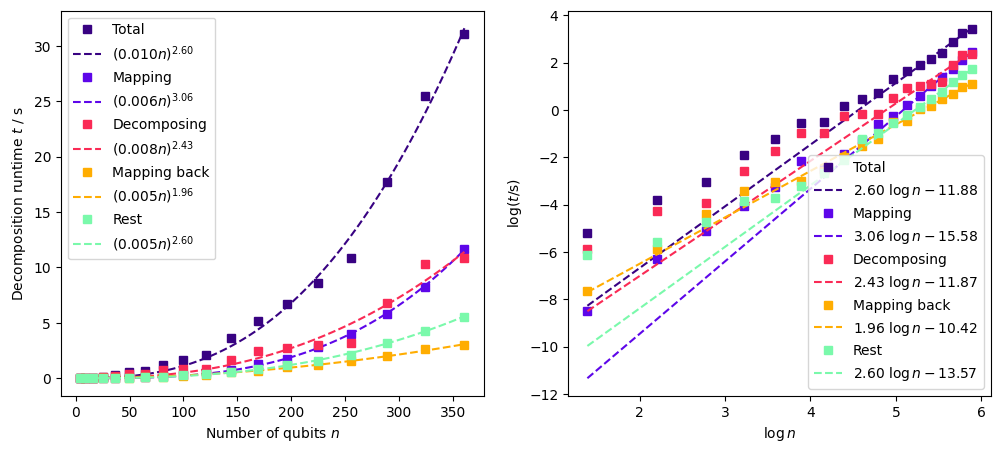

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
all_times = [times_total, times_mapping, times_decomposing, times_mapping_back, times_rest]
colors = ["xkcd:indigo", "xkcd:blue violet", "xkcd:red pink", "xkcd:orange yellow", "xkcd:seafoam green"]
labels = ["Total", "Mapping", "Decomposing", "Mapping back", "Rest"]
for times, label, c in zip(all_times, labels, colors):
    # f = lambda x, a, b: a * x + b
    f = lambda x, a, b: (b * x)**a
    # popt, pcov = curve_fit(f, np.log(ns)[3:], np.log(times)[3:])
    popt, pcov = curve_fit(f, ns, times)
    cont_ns = np.linspace(ns[0], ns[-1], 100)
    
    ax = axs[0]
    ax.plot(ns, times, marker="s", c=c, label=label, ls="")
    # ax.plot(cont_ns, np.exp(f(np.log(cont_ns), *popt)), ls = "--", c="xkcd:red pink", label=f"${popt[1]:.1f}n^{{{popt[0]:.2f}}}$")
    ax.plot(cont_ns, f(cont_ns, *popt), ls = "--", c=c, label=f"$({popt[1]:.3f}n)^{{{popt[0]:.2f}}}$")
    ax.set_xlabel("Number of qubits $n$")
    ax.set_ylabel("Decomposition runtime $t$ / s")
    ax.legend()
    ax = axs[1]
    ax.plot(np.log(ns), np.log(times), marker="s", c=c, label=label, ls="")
    # ax.plot(np.log(ns), f(np.log(ns), *popt), ls = "--", c="xkcd:red pink", label=f"${popt[0]:.2f}\ \log n {popt[1]:.1f}$")
    ax.plot(np.log(cont_ns), np.log(f(cont_ns, *popt)), ls = "--", c=c, label=f"${popt[0]:.2f}\ \log n {popt[0] * np.log(popt[1]):.2f}$")
    ax.set_xlabel("$\log n$")
    ax.set_ylabel("$\log (t/\\text{s})$")
    ax.legend()